- **paper : A Closer Look at Memorization in Deep Networks**
    - doi : https://doi.org/10.48550/arXiv.1706.05394
    - summary : https://astonishing-antlion-13b.notion.site/A-Closer-Look-at-Memorization-in-Deep-Networks-24ce61796c42800f833ecd17c814fbd2?source=copy_link
- **abstract**
    - `We examine the role of memorization in deep
learning, drawing connections to capacity, generalization, and adversarial robustness. While
deep networks are capable of memorizing noise
data, our results suggest that they tend to prioritize learning simple patterns first. In our
experiments, we expose qualitative differences
in gradient-based optimization of deep neural
networks (DNNs) on noise vs. real data. We
also demonstrate that for appropriately tuned
explicit regularization (e.g., dropout) we can
degrade DNN training performance on noise
datasets without compromising generalization on
real data. Our analysis suggests that the notions
of effective capacity which are dataset independent are unlikely to explain the generalization
performance of deep networks when trained with
gradient based methods because training data itself plays an important role in determining the
degree of memorization.`



In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print (device)

cuda


In [3]:
transform = transforms.ToTensor()
train_DS = datasets.CIFAR10(root='./',
                         train=True,
                         download=True,
                         transform=transform)
test_DS = datasets.CIFAR10(root='./',
                         train=False,
                         download=True,
                         transform=transform)

print (train_DS)
print (test_DS)
print (len(train_DS))
print (len(test_DS))

100%|██████████| 170M/170M [00:25<00:00, 6.65MB/s]


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()
50000
10000


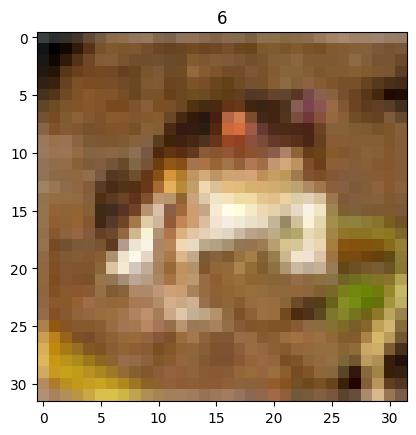

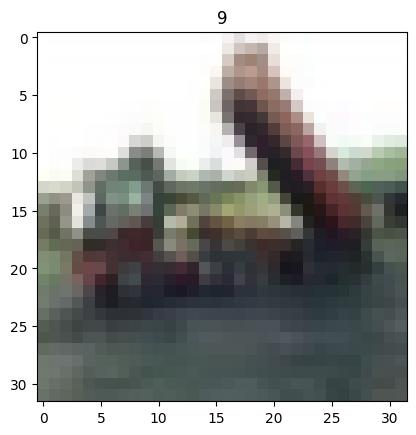

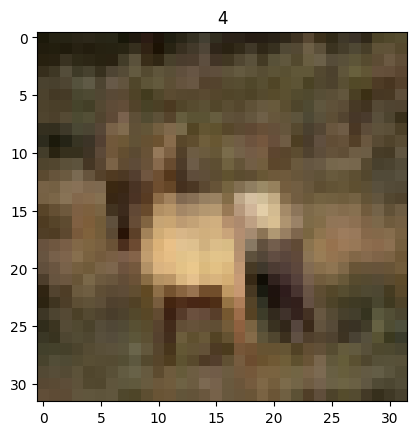

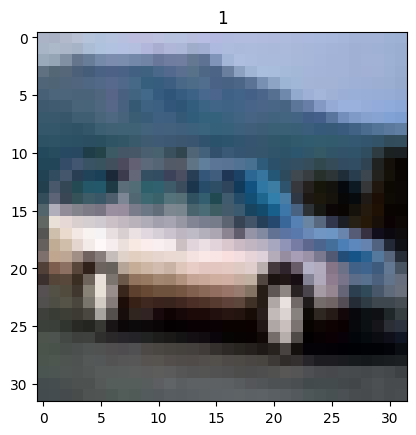

In [4]:
for i in range (5) :
    plt.title(train_DS.targets[i])
    plt.imshow(train_DS.data[i],
          cmap='gray')
    plt.show()

In [5]:
X_train = train_DS.data.copy()
y_train = train_DS.targets.copy()

X_test = test_DS.data.copy()
y_test = test_DS.targets.copy()

print (X_train.shape)

(50000, 32, 32, 3)


In [7]:
# get dataset and dataloader

batch_size = 256
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, X, y, transform=None):

        self.X = torch.tensor(X, dtype=torch.float32) / 255.0
        self.y = torch.tensor(y, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

train_DL = DataLoader(Dataset(X_train, y_train),
                     batch_size=batch_size,
                     shuffle=True)

test_DL = DataLoader(test_DS,
                     batch_size=batch_size,
                     shuffle=True)


print (train_DL.dataset)
print (len(train_DL))

196


In [10]:
# ConvNet

!pip install torchinfo
from torch import nn, optim
from torchinfo import summary

class ConvNet(nn.Module):
    def __init__(self, flattened_size):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.maxpool1(x)
        x = self.conv_block2(x)
        x = self.maxpool2(x)
        x = self.conv_block3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

def get_flattened_size(model, input_size=(3, 32, 32)):
  with torch.no_grad():
      x = torch.zeros(1, *input_size).to(device)
      x = model.conv_block1(x)
      x = model.maxpool1(x)
      x = model.conv_block2(x)
      x = model.maxpool2(x)
      x = model.conv_block3(x)
      x = model.maxpool3(x)
      return x.numel()  # batch 제외 전체 요소 수

model_tmp = ConvNet(flattened_size=1).to(device)
flat_size = get_flattened_size(model_tmp)
print(f'Flattened size: {flat_size}')

model = ConvNet(flat_size).to(device)
summary(model, input_size=(batch_size, 3, 32, 32))

Flattened size: 1152


Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [256, 10]                 --
├─Sequential: 1-1                        [256, 32, 32, 32]         --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [256, 32, 32, 32]         64
│    └─ReLU: 2-3                         [256, 32, 32, 32]         --
├─MaxPool2d: 1-2                         [256, 32, 15, 15]         --
├─Sequential: 1-3                        [256, 64, 15, 15]         --
│    └─Conv2d: 2-4                       [256, 64, 15, 15]         18,496
│    └─BatchNorm2d: 2-5                  [256, 64, 15, 15]         128
│    └─ReLU: 2-6                         [256, 64, 15, 15]         --
├─MaxPool2d: 1-4                         [256, 64, 7, 7]           --
├─Sequential: 1-5                        [256, 128, 7, 7]          --
│    └─Conv2d: 2-7                       [256, 128, 7, 7]          73,856
│    

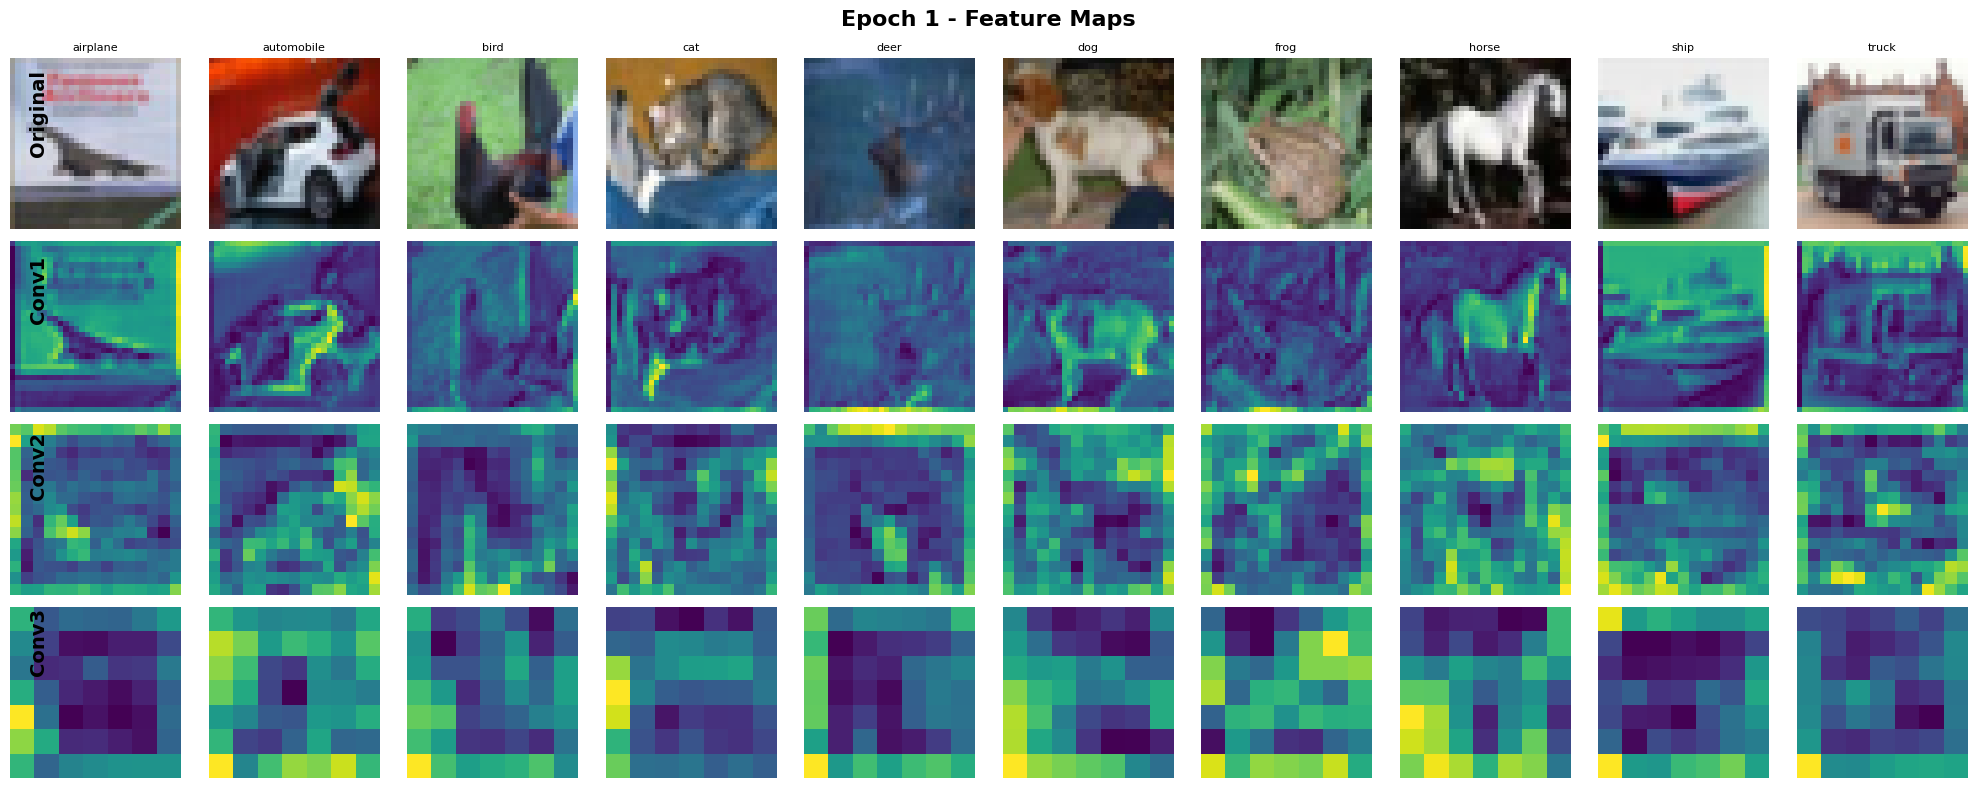

epoch 1 : train_loss 328.9551


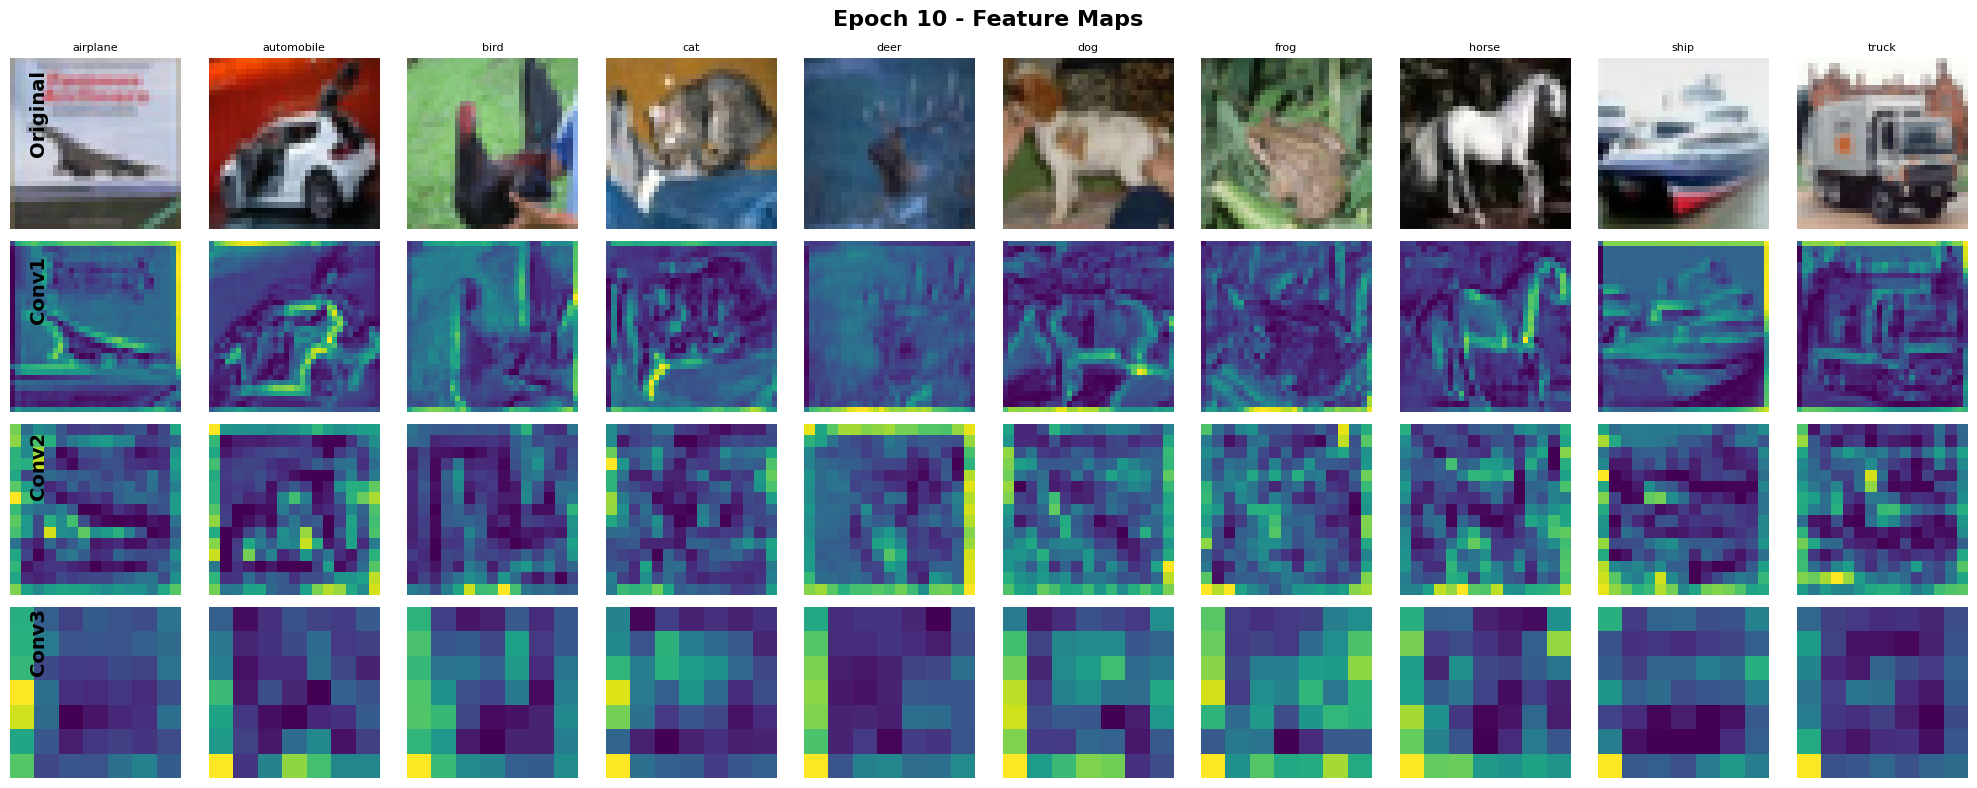

epoch 10 : train_loss 74.2016


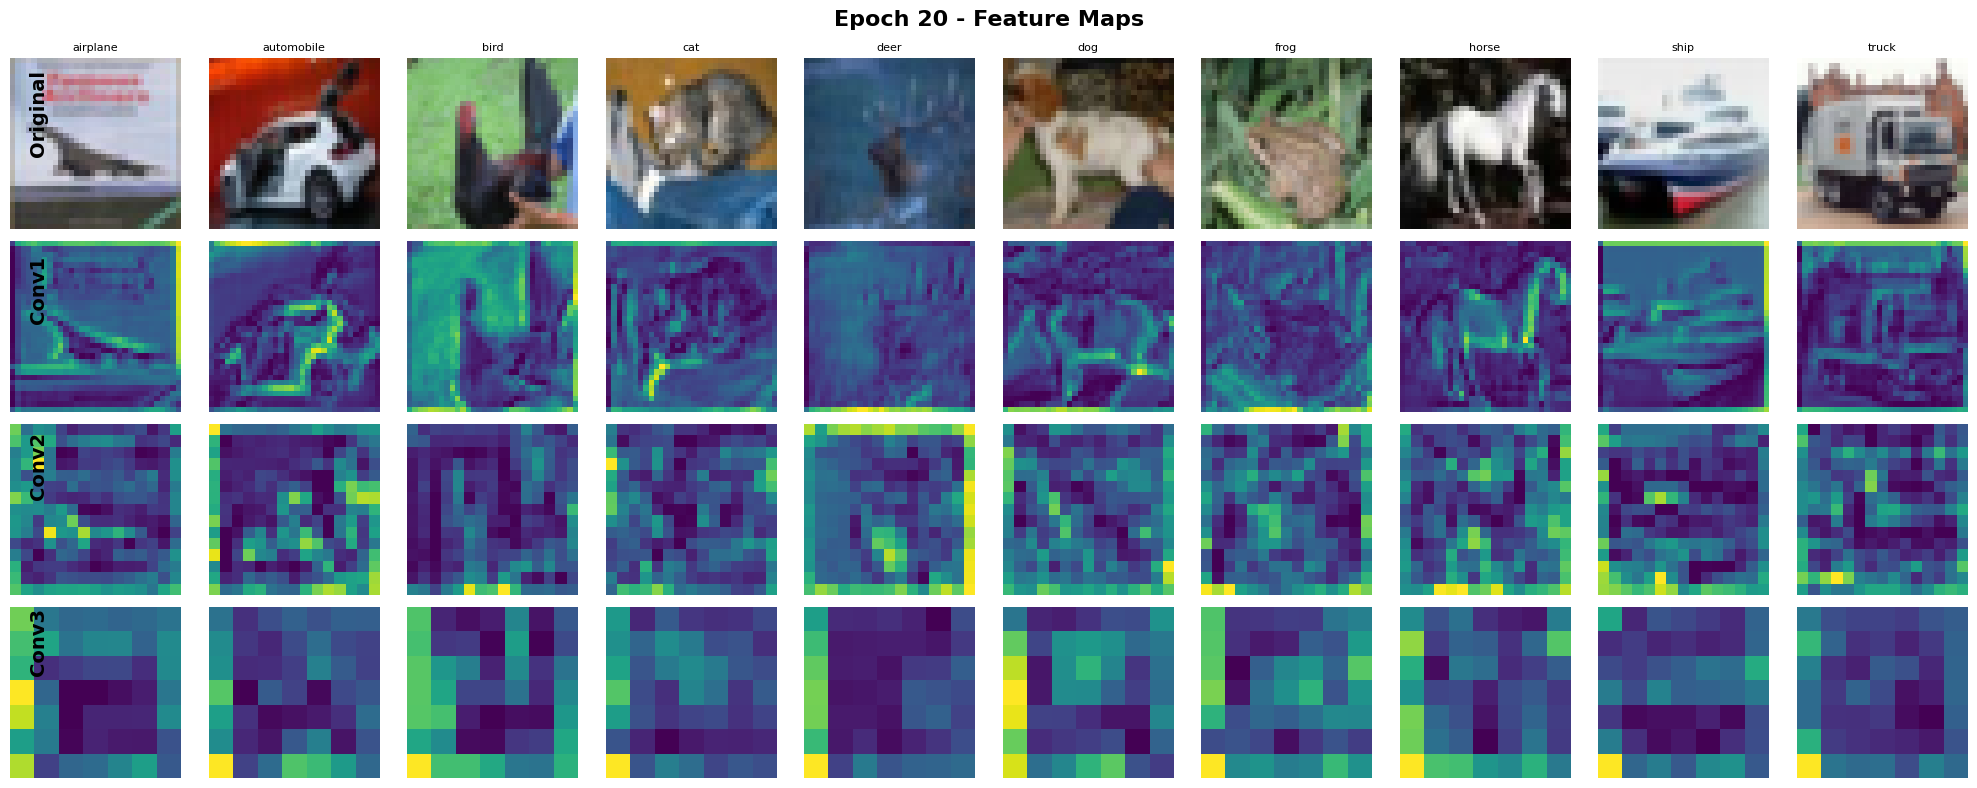

epoch 20 : train_loss 30.4911
epoch 30 : train_loss 21.7517
epoch 40 : train_loss 14.9600


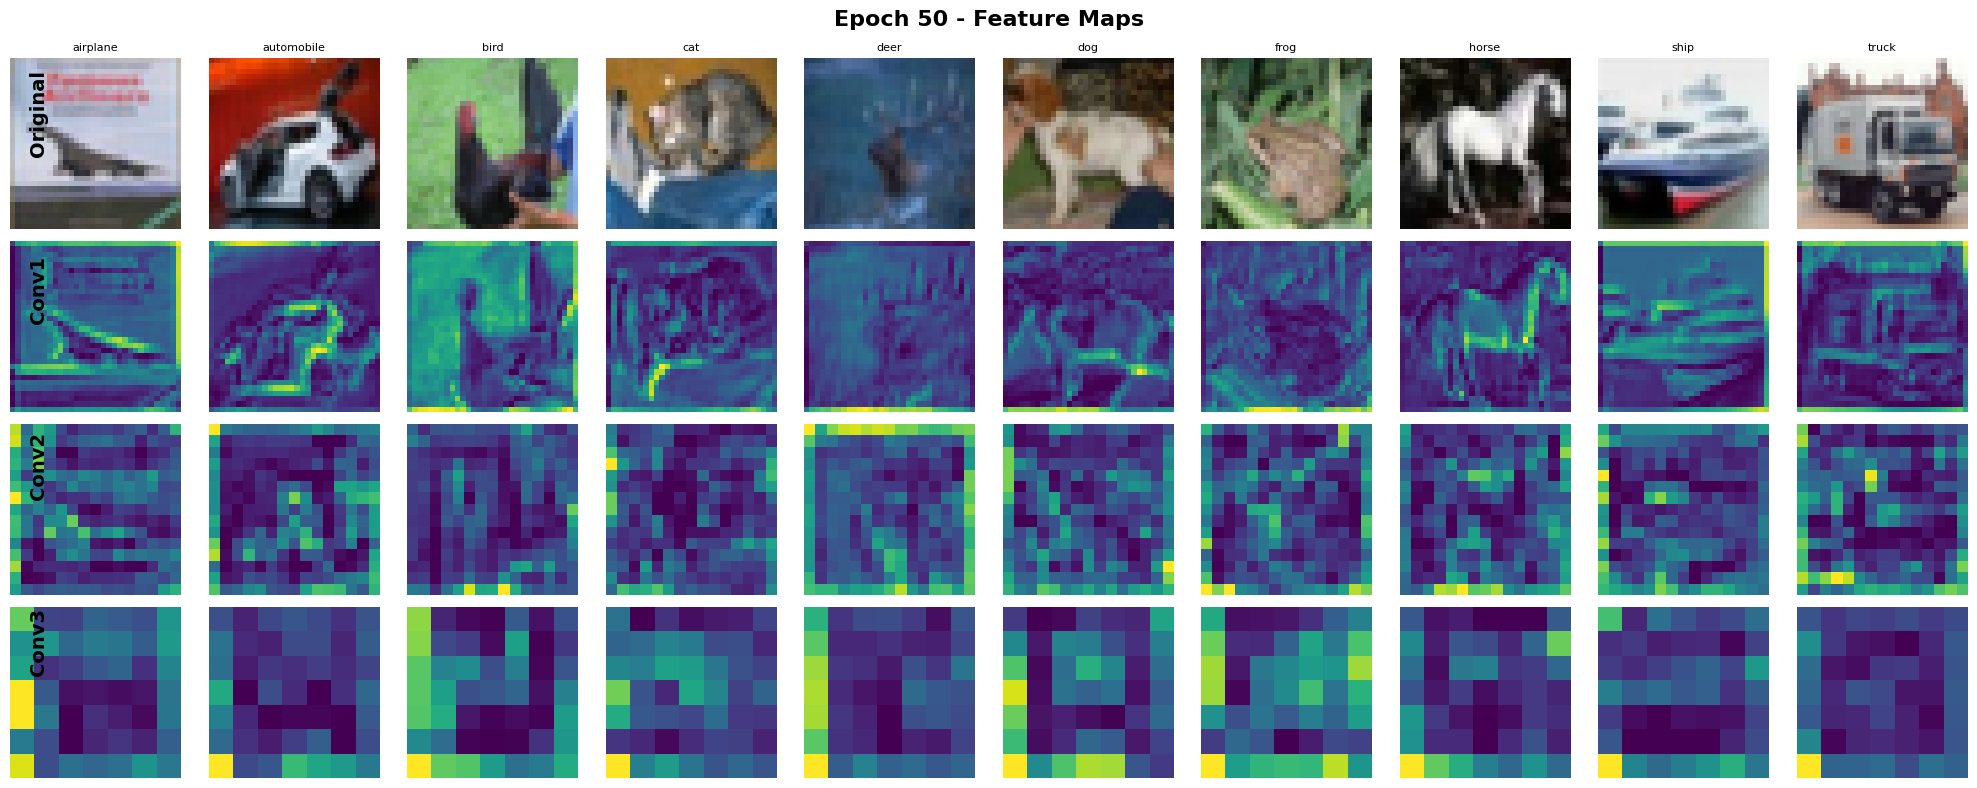

epoch 50 : train_loss 13.4813
epoch 60 : train_loss 12.7896
epoch 70 : train_loss 9.4112
epoch 80 : train_loss 8.5337
epoch 90 : train_loss 7.1984


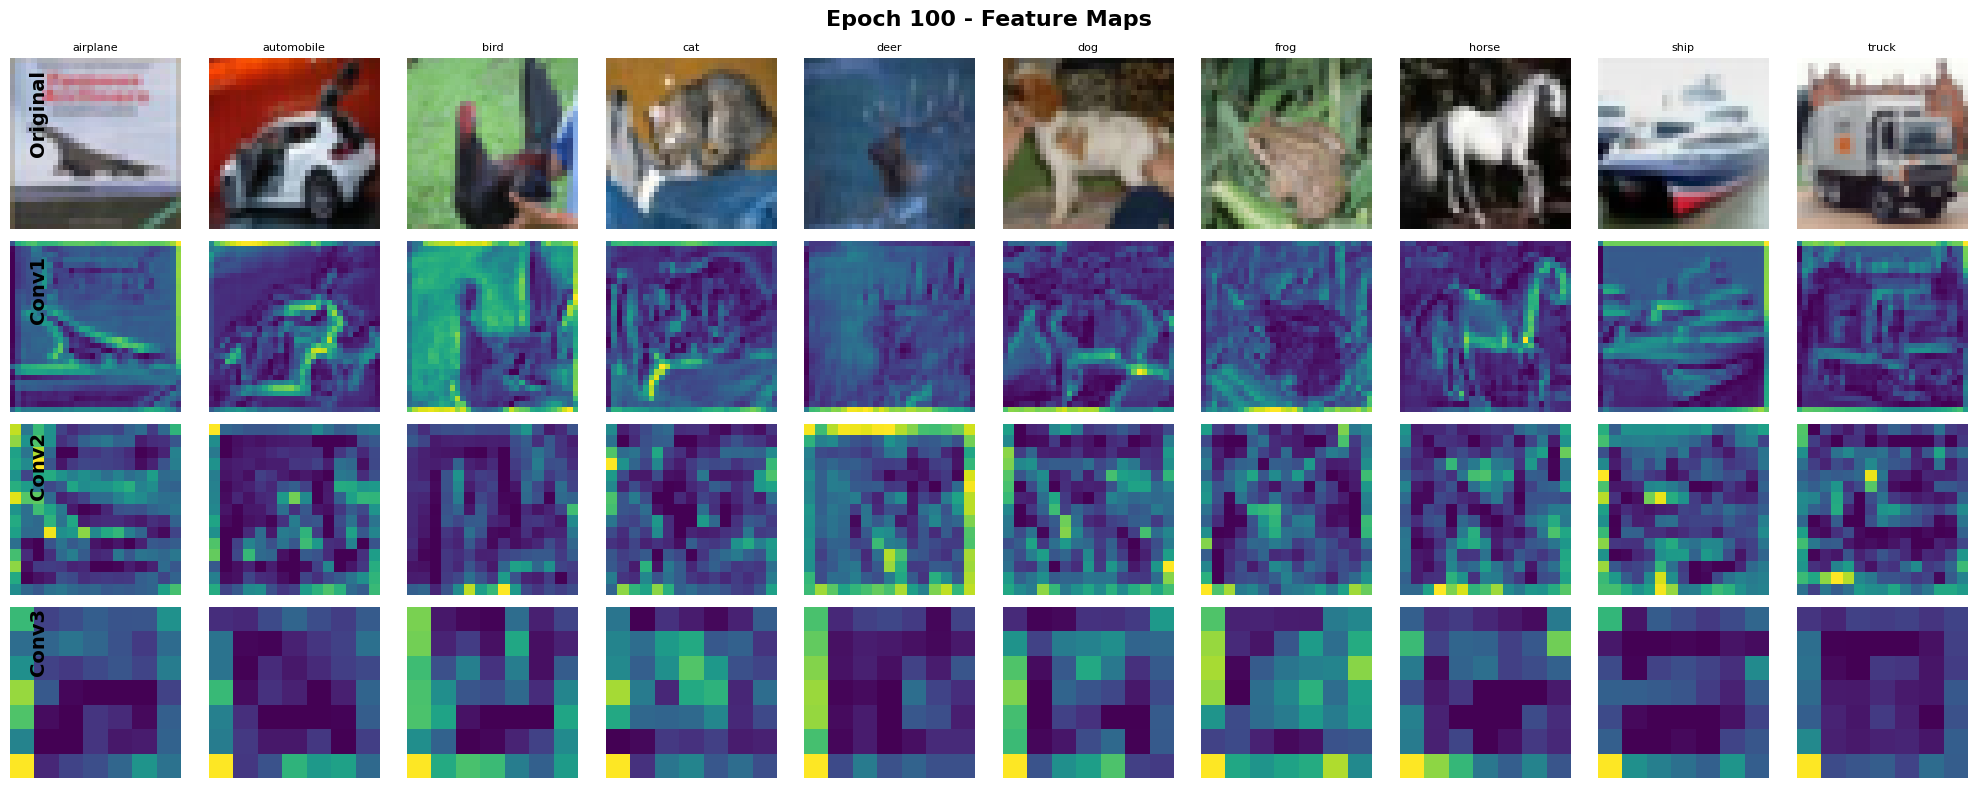

epoch 100 : train_loss 7.2551


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 특징맵을 추출하기 위한 훅 함수들
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.features = {}
        self.hooks = []

        # 각 conv block에 훅 등록
        self.hooks.append(model.conv_block1.register_forward_hook(
            lambda module, input, output: self.save_feature('conv1', output)))
        self.hooks.append(model.conv_block2.register_forward_hook(
            lambda module, input, output: self.save_feature('conv2', output)))
        self.hooks.append(model.conv_block3.register_forward_hook(
            lambda module, input, output: self.save_feature('conv3', output)))

    def save_feature(self, name, output):
        self.features[name] = output.detach().cpu()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

# 클래스별로 대표 이미지 하나씩 선택
def select_representative_images(dataset, num_classes=10):
    class_samples = {i: None for i in range(num_classes)}
    class_found = {i: False for i in range(num_classes)}

    for idx in range(len(dataset.data)):
        label = dataset.targets[idx]
        if not class_found[label]:
            image = dataset.data[idx]  # numpy array (H, W, C)
            image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
            class_samples[label] = (image_tensor, label, idx)
            class_found[label] = True

        if all(class_found.values()):
            break

    return class_samples

# 특징맵 시각화 함수
def visualize_feature_maps(feature_map, max_channels=8):
    if len(feature_map.shape) == 4:
        feature_map = feature_map[0]

    num_channels = min(feature_map.shape[0], max_channels)
    avg_feature = torch.mean(feature_map[:num_channels], dim=0)

    plt.imshow(avg_feature.numpy(), cmap='viridis')
    plt.axis('off')

# epoch별 시각화 함수
def visualize_epoch_features(epoch_features, epoch, class_names):
    fig, axes = plt.subplots(4, 10, figsize=(20, 8))
    fig.suptitle(f'Epoch {epoch} - Feature Maps', fontsize=16, fontweight='bold')

    for class_idx in range(10):
        # Row 0: Original images
        plt.subplot(4, 10, class_idx + 1)
        plt.imshow(epoch_features[class_idx]['original'].numpy())
        plt.title(f'{class_names[class_idx]}', fontsize=8)
        plt.axis('off')

        # Row 1: Conv1 features
        plt.subplot(4, 10, 10 + class_idx + 1)
        visualize_feature_maps(epoch_features[class_idx]['conv1'])
        plt.axis('off')

        # Row 2: Conv2 features
        plt.subplot(4, 10, 20 + class_idx + 1)
        visualize_feature_maps(epoch_features[class_idx]['conv2'])
        plt.axis('off')

        # Row 3: Conv3 features
        plt.subplot(4, 10, 30 + class_idx + 1)
        visualize_feature_maps(epoch_features[class_idx]['conv3'])
        plt.axis('off')

    # Row labels
    row_labels = ['Original', 'Conv1', 'Conv2', 'Conv3']
    for i, label in enumerate(row_labels):
        fig.text(0.02, 0.85 - i*0.22, label, fontsize=14, fontweight='bold', rotation=90, va='center')

    plt.tight_layout()
    plt.savefig(f'epoch_{epoch}_features.png', dpi=150, bbox_inches='tight')
    plt.show()

# 학습 및 시각화 코드
def train_and_visualize(model, train_DL, test_samples, device, epochs=100, viz_epochs=[1, 10, 20, 50, 100]):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    for ep in range(epochs):
        model.train()
        train_loss = 0
        N = 0

        for X_batch, y_batch in train_DL:
            N += 1
            X_batch = X_batch.permute(0, 3, 1, 2).to(device)
            y_batch = y_batch.to(device)
            y_hat = model(X_batch)

            loss = criterion(y_hat, y_batch)
            train_loss += loss.item() * X_batch.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 특정 epoch에서 특징맵 추출 및 시각화
        if (ep + 1) in viz_epochs:
            model.eval()
            extractor = FeatureExtractor(model)
            epoch_features = {}

            with torch.no_grad():
                for class_idx in range(10):
                    if class_idx in test_samples:
                        image, label, _ = test_samples[class_idx]
                        image_batch = image.permute(2, 0, 1).unsqueeze(0).to(device)

                        _ = model(image_batch)

                        epoch_features[class_idx] = {
                            'original': image,
                            'conv1': extractor.features['conv1'].clone(),
                            'conv2': extractor.features['conv2'].clone(),
                            'conv3': extractor.features['conv3'].clone()
                        }

            extractor.remove_hooks()

            # 이 epoch의 특징맵들을 시각화
            visualize_epoch_features(epoch_features, ep + 1, class_names)

        if (ep + 1) % 10 == 0 or (ep + 1) in viz_epochs:
            print(f'epoch {ep+1} : train_loss {train_loss/N:.4f}')

    return model

test_samples = select_representative_images(test_DS)
model = ConvNet(flat_size).to(device)
trained_model = train_and_visualize(model, train_DL, test_samples, device, epochs=100, viz_epochs=[1, 10, 20, 50, 100])